In [1]:
# importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
(xtrain,ytrain),(xtest,ytest) = cifar10.load_data()  # loading the data

In [3]:
xtrain[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [4]:
# preprocessing(normalizing) the xtrain and xtest

xtrain = preprocess_input(xtrain[:2000])  # taking only 2000 images for training
xtest = preprocess_input(xtest[:500])     # taking only 500 images for training

ytrain = ytrain[:2000]
ytest = ytest[:500]

In [5]:
xtrain[0]

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921573,  0.03529418, -0.15294117],
        [ 0.19215691, -0.01960784, -0.19999999],
        [ 0.16078436, -0.02745098, -0.19215685]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.3098039 , -0.5686275 ],
        [-0.06666666, -0.3490196 , -0.60784316],
        [-0.04313725, -0.31764704, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.0745098 , -0.34117645, -0.60784316],
        [-0.05882353, -0.34117645, -0.60784316],
        [-0.14509803, -0.42745095, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333337, -0.24705881],
        [ 0

In [6]:
print(f'xtrain shape -', xtrain.shape)
print(f'xtest shape -', xtest.shape)

xtrain shape - (2000, 32, 32, 3)
xtest shape - (500, 32, 32, 3)


Resizing the images as Inception model takes input size as (75,75,3) or more

In [7]:
import cv2
def resize(images,new_size): #75
  resized_images = []
  for image in images:
    resized_image = cv2.resize(image,(new_size,new_size))
    # resized_image = cv2.resize(image,new_size)
    resized_images.append(resized_image)
  return np.array(resized_images)

xtrain = resize(xtrain,75)
xtest = resize(xtest,75)
print(f'xtrain shape -', xtrain.shape)
print(f'xtest shape -', xtest.shape)

xtrain shape - (2000, 75, 75, 3)
xtest shape - (500, 75, 75, 3)


Performing One Hot Encoding on label or output names

In [8]:
ytrain[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [9]:
ytrain = to_categorical(ytrain)   # uses to_categorical to perform one hot encoder
ytest = to_categorical(ytest)

In [10]:
ytrain[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
ytest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Training the InceptionV3 model

In [12]:
inceptionV3model = InceptionV3(weights = "imagenet",include_top = False,input_shape = (75,75,3))  # InceptionV3 block

cnn_block = inceptionV3model.output  # CNN block

flattenpart = GlobalAveragePooling2D()(cnn_block)  # flatten block

# ANN block
annpart = Dense(1924,activation = "relu")(flattenpart)
hiddenann = Dense(520,activation = "relu")(annpart)
outputlayer = Dense(10,activation = "softmax")(hiddenann)
model = Model(inputs = inceptionV3model.input, outputs = outputlayer)

# compiling the model
model.compile(optimizer = "adam", loss = "categorical_crossentropy",metrics = ["accuracy"])
model.fit(xtrain,ytrain, epochs = 200)

Epoch 1/200
63/63 [==============================] - 48s 102ms/step - loss: 2.1594 - accuracy: 0.2160
Epoch 2/200
63/63 [==============================] - 4s 67ms/step - loss: 1.7641 - accuracy: 0.3485
Epoch 3/200
63/63 [==============================] - 3s 55ms/step - loss: 1.6251 - accuracy: 0.4080
Epoch 4/200
63/63 [==============================] - 3s 55ms/step - loss: 1.5459 - accuracy: 0.4445
Epoch 5/200
63/63 [==============================] - 4s 61ms/step - loss: 1.5178 - accuracy: 0.4635
Epoch 6/200
63/63 [==============================] - 4s 63ms/step - loss: 1.6993 - accuracy: 0.3745
Epoch 7/200
63/63 [==============================] - 4s 56ms/step - loss: 1.6939 - accuracy: 0.3840
Epoch 8/200
63/63 [==============================] - 4s 56ms/step - loss: 1.6826 - accuracy: 0.3735
Epoch 9/200
63/63 [==============================] - 4s 68ms/step - loss: 1.8914 - accuracy: 0.2760
Epoch 10/200
63/63 [==============================] - 4s 57ms/step - loss: 1.7045 - accuracy: 0.37

In [13]:
# evaluating the models performance
model.evaluate(xtest,ytest)

16/16 [==============================] - 4s 123ms/step - loss: 2.7420 - accuracy: 0.5300


[2.7419862747192383, 0.5299999713897705]

Checking models performance on image

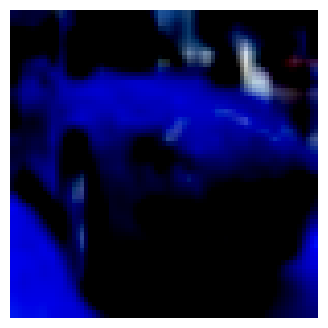

In [14]:
# Extract the image
image = xtrain[5]

# Convert the image to RGB format (CIFAR-10 images are in BGR format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [15]:
# resizing the image
resized_image = cv2.resize(image, (75, 75))
resized_image = np.expand_dims(resized_image, axis=0)
resized_image.shape

(1, 75, 75, 3)

In [16]:
output = model.predict(resized_image)

1/1 [==============================] - 2s 2s/step


In [17]:
class_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [18]:
output

array([[5.6295969e-05, 9.9959546e-01, 3.1492068e-06, 2.1850862e-07,
        3.2487762e-06, 1.1359498e-05, 4.0343763e-05, 2.8980769e-06,
        9.1189904e-06, 2.7804618e-04]], dtype=float32)

In [19]:
labelindex=np.argmax(output)

In [20]:
class_labels[labelindex]

'automobile'